# e-footprint quickstart

This notebook provides an example scenario that you can use to get familiar with the Pyhton API of efootprint: the daily video consumption of all French households on a big streaming platform.

You will get to describe:
- the infrastructure involved (serveurs with auto-scaling settings, storage, service and network)
- the user journey involving 2 steps (Streaming, Upload)
- the usage pattern and the device population that executes it (the laptops of all French households)

## Import the packages

⚠ If this steps fails, remember to run *ipython kernel install --user --name=efootprint-kernel* _inside_ your python virtual environement (initializable with `poetry install`) to be able to select efootprint-kernel as the jupyter kernel.

In [1]:
from efootprint.abstract_modeling_classes.source_objects import SourceValue, Sources, SourceObject
from efootprint.core.usage.user_journey import UserJourney, UserJourneyStep
from efootprint.core.hardware.servers.autoscaling import Autoscaling
from efootprint.core.hardware.storage import Storage
from efootprint.core.service import Service
from efootprint.core.hardware.device_population import DevicePopulation
from efootprint.core.usage.usage_pattern import UsagePattern
from efootprint.core.hardware.network import Network
from efootprint.core.system import System
from efootprint.constants.countries import Countries
from efootprint.constants.units import u
from efootprint.utils.object_relationships_graphs import USAGE_PATTERN_VIEW_CLASSES_TO_IGNORE
from efootprint.builders.hardware.devices_defaults import default_laptop

import os

## Define the infrastructure

An e-footprint object has a name and attributes describing its technical and environmental characteristics:

In [2]:
server = Autoscaling(
    "Autoscaling server",
    carbon_footprint_fabrication=SourceValue(600 * u.kg, Sources.BASE_ADEME_V19),
    power=SourceValue(300 * u.W, Sources.HYPOTHESIS),
    lifespan=SourceValue(6 * u.year, Sources.HYPOTHESIS),
    idle_power=SourceValue(50 * u.W, Sources.HYPOTHESIS),
    ram=SourceValue(128 * u.GB, Sources.HYPOTHESIS),
    cpu_cores=SourceValue(24 * u.core, Sources.HYPOTHESIS),
    power_usage_effectiveness=SourceValue(1.2 * u.dimensionless, Sources.HYPOTHESIS),
    average_carbon_intensity=SourceValue(100 * u.g / u.kWh, Sources.HYPOTHESIS),
    server_utilization_rate=SourceValue(0.9 * u.dimensionless, Sources.HYPOTHESIS))

Moreover, all e-footprint objects have a *calculated_attributes* attributes that shows the list of attributes that are setup as None and then computed by e-footprint when the modeling is over. For example, for our server:

In [3]:
print(server.calculated_attributes)

['available_ram_per_instance', 'available_cpu_per_instance', 'all_services_cpu_needs', 'all_services_ram_needs', 'fraction_of_time_in_use', 'nb_of_instances', 'instances_fabrication_footprint', 'instances_power', 'energy_footprint']


More information on e-footprint objects’ calculated_attributes can be found in the [e-footprint documentation](https://publicissapient-france.github.io/e-footprint/).

In [4]:
storage = Storage(
    "SSD storage",
    carbon_footprint_fabrication=SourceValue(160 * u.kg, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    power=SourceValue(1.3 * u.W, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    lifespan=SourceValue(6 * u.years, Sources.HYPOTHESIS),
    idle_power=SourceValue(0 * u.W, Sources.HYPOTHESIS),
    storage_capacity=SourceValue(1 * u.TB, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    power_usage_effectiveness=SourceValue(1.2 * u.dimensionless, Sources.HYPOTHESIS),
    average_carbon_intensity=SourceValue(100 * u.g / u.kWh),
    data_replication_factor=SourceValue(3 * u.dimensionless, Sources.HYPOTHESIS))

Apart from environmental and technical attributes, e-footprint objects can link to other e-footprint objects. For example, the following service runs on the server and uploads data to the storage:

In [5]:
service = Service(
    "Streaming platform",
    server=server,
    storage=storage,
    base_ram_consumption=SourceValue(300 * u.MB, Sources.HYPOTHESIS),
    base_cpu_consumption=SourceValue(2 * u.core, Sources.HYPOTHESIS))

## Define the user journey

This is the modeling of the average daily usage of the streaming platform in France:

In [6]:
streaming_step = UserJourneyStep(
    "20 min streaming",
    service=service,
    data_upload=SourceValue(50 * u.kB / u.uj, Sources.USER_DATA),
    data_download=SourceValue((2.5 / 3) * u.GB / u.uj, Sources.USER_DATA),
    user_time_spent=SourceValue(20 * u.min / u.uj, Sources.USER_DATA),
    request_duration=SourceValue(4 * u.min, Sources.HYPOTHESIS),
    cpu_needed=SourceValue(1 * u.core / u.uj, Sources.HYPOTHESIS),
    ram_needed=SourceValue(50 * u.MB / u.uj, Sources.HYPOTHESIS))
upload_step = UserJourneyStep(
    "0.4s of upload",
    service=service,
    data_upload=SourceValue(300 * u.kB / u.uj, Sources.USER_DATA),
    data_download=SourceValue(0 * u.GB / u.uj, Sources.USER_DATA),
    user_time_spent=SourceValue(0.4 * u.s / u.uj, Sources.USER_DATA),
    request_duration=SourceValue(0.4 * u.s, Sources.HYPOTHESIS),
    cpu_needed=SourceValue(1 * u.core / u.uj, Sources.HYPOTHESIS),
    ram_needed=SourceValue(50 * u.MB / u.uj, Sources.HYPOTHESIS)
)

2024-03-08 12:28:33,400 - INFO - Computing calculated attributes for UserJourneyStep 20 min streaming
2024-03-08 12:28:33,404 - INFO - Computing calculated attributes for UserJourneyStep 0.4s of upload


The user journey is then simply a list of user journey steps:

In [7]:
user_journey = UserJourney("Mean video consumption user journey", uj_steps=[streaming_step, upload_step])

2024-03-08 12:28:33,411 - INFO - Computing calculated attributes for UserJourney Mean video consumption user journey


## Define the device population and how often it runs the user journey

In [8]:
device_population = DevicePopulation(
    "French households’ laptops",
    nb_devices=SourceValue(4e7 * 0.3 * u.user, Sources.USER_DATA),
    country=Countries.FRANCE(),
    devices=[default_laptop()])

network = Network(
        "WIFI network",
        bandwidth_energy_intensity=SourceValue(0.05 * u("kWh/GB"), Sources.TRAFICOM_STUDY))

usage_pattern = UsagePattern(
    "Daily video streaming consumption",
    user_journey=user_journey,
    device_population=device_population,
    network=network,
    user_journey_freq_per_user=SourceValue(365 * u.user_journey / (u.user * u.year), Sources.USER_DATA),
    time_intervals=SourceObject([[7, 12], [17, 23]]))

system = System("System", usage_patterns=[usage_pattern])

2024-03-08 12:28:33,430 - INFO - Computing calculated attributes for System System
2024-03-08 12:28:33,432 - INFO - Computing calculated attributes for UsagePattern Daily video streaming consumption
2024-03-08 12:28:33,433 - INFO - Computing calculated attributes for DevicePopulation French households’ laptops
2024-03-08 12:28:33,440 - INFO - Computing calculated attributes for Service Streaming platform
2024-03-08 12:28:33,449 - INFO - Computing calculated attributes for Network WIFI network
2024-03-08 12:28:33,453 - INFO - Computing calculated attributes for Autoscaling Autoscaling server
2024-03-08 12:28:33,461 - INFO - Computing calculated attributes for Storage SSD storage


## Results

### Computed attributes

Now all calculated_attributes have been computed:

In [9]:
print(f"Server carbon footprint is {(server.energy_footprint + server.instances_fabrication_footprint).value}")
print(f"Total system carbon footprint is {system.total_footprint.value}")


Server carbon footprint is 707604.7183333335 kilogram / year
Total system carbon footprint is 37408251.09958489 kilogram / year


### Object relationships graph

In [10]:
usage_pattern.object_relationship_graph_to_file("object_relationships_graph.html",
    classes_to_ignore=USAGE_PATTERN_VIEW_CLASSES_TO_IGNORE, width=800, height=300, notebook=True)

object_relationships_graph.html


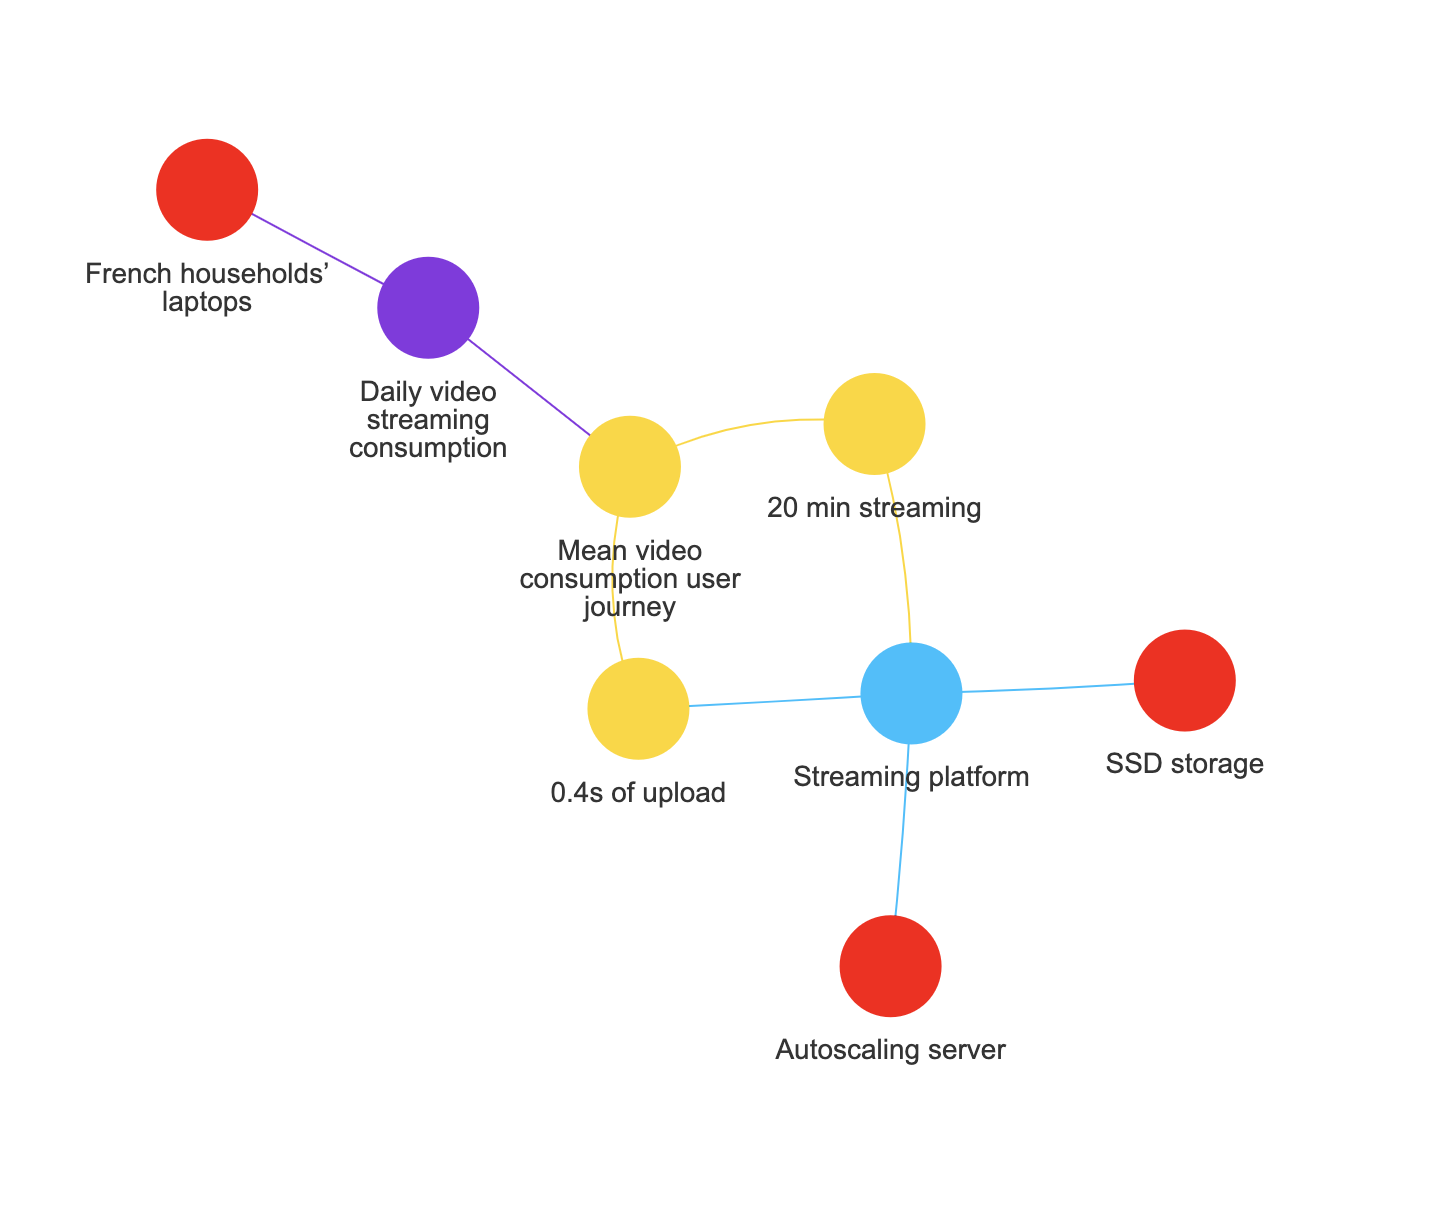

In [11]:
# Static display for github, works only from e-footprint repository base folder
from IPython.display import display, Image

display(Image(filename=os.path.join("images", "obj_relationships_graph_example.png"), width=500, height=50))

### Calculus graph

Any e-footprint calculation can generate its calculation graph for full auditability. Hover on a calculus node to display its formula and numeric value.

In [12]:
device_population.instances_fabrication_footprint.calculus_graph_to_file(
    "device_population_fab_footprint_calculus_graph.html", width=800, height=500, notebook=True)

device_population_fab_footprint_calculus_graph.html


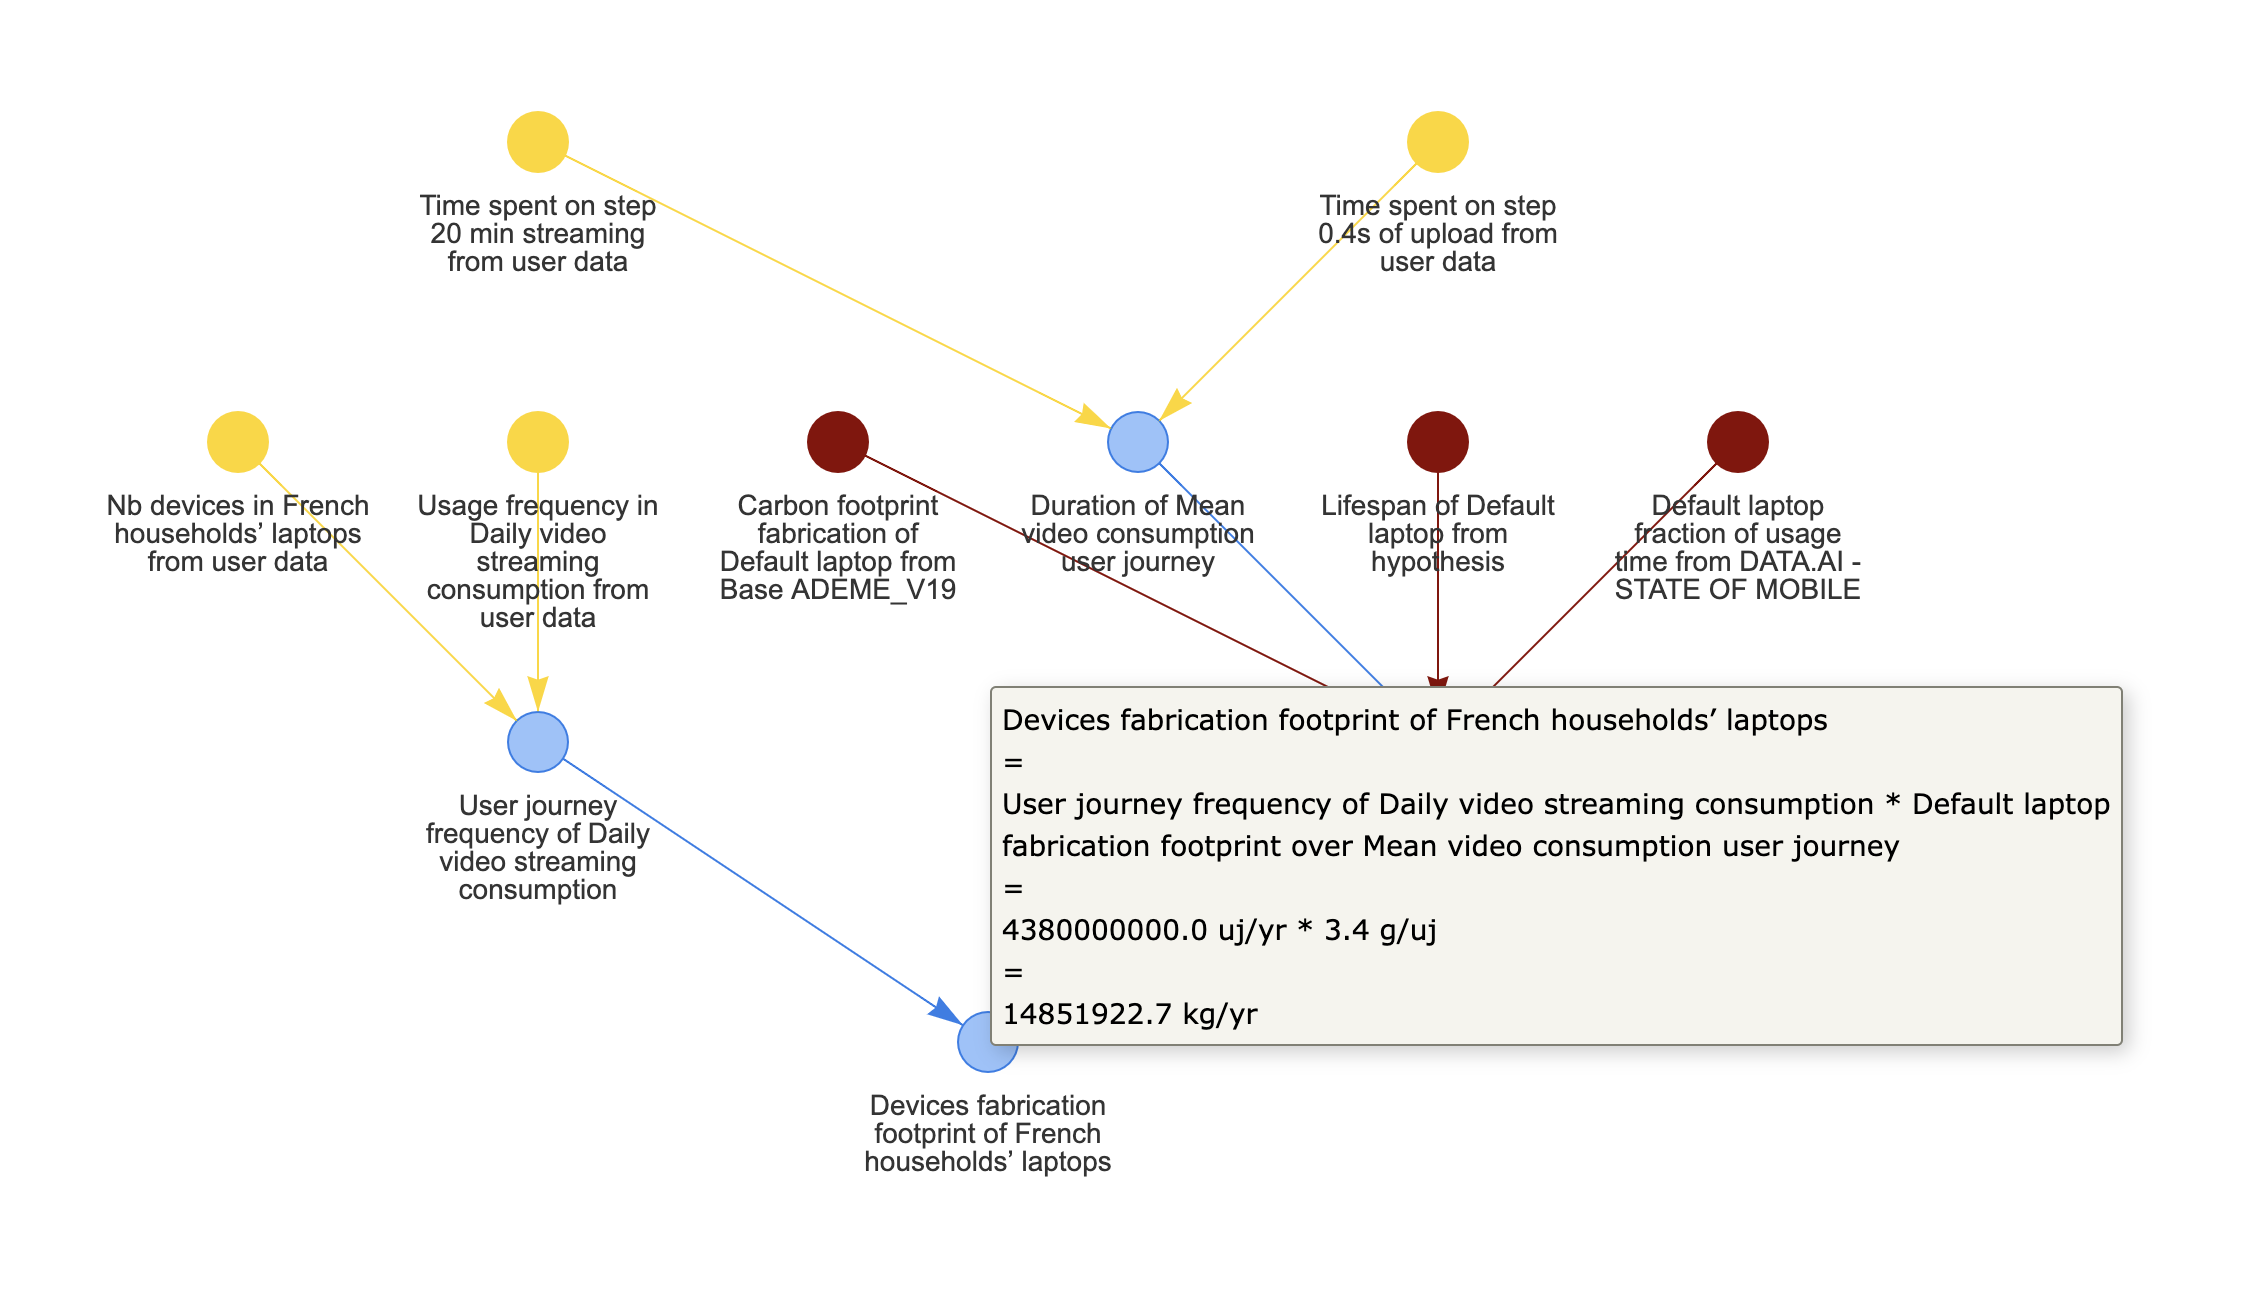

In [13]:
# Static display for github, works only from e-footprint repository base folder
from IPython.display import display, Image

display(Image(filename=os.path.join("images", "device_population_fab_footprint_calculus_graph_example.png"), width=800, height=500))